## Test MatchHistogram 'group_by' behavior
The API doc for `starfish.image.Filter.MatchHistograms` says 
```
Setting group_by={Axes.CH} would carry out the same approach, but the result would _retain_ variation across channel.
```

I think it would retain variation across rounds and normalize variation across channels.

Plan:
* Compare group_by={Axes.CH, Axes.ROUND} with group_by={Axes.CH} and group_by={Axes.ROUND}
* Use STARmap and DARTFISH example FOV
* Use `scipy.stats.ks_2samp` to measure histogram similarity

In [1]:
import starfish.data
import matplotlib.pyplot as plt
from starfish.types import Axes
from starfish.util.plot import imshow_plane, intensity_histogram

from starfish import FieldOfView

In [2]:
# Load one FOV from STARmap data and DARTFISH data
sm_experiment = starfish.data.STARmap(use_test_data=False)
sm_stack = sm_experiment.fov().get_image(FieldOfView.PRIMARY_IMAGES)
print(sm_stack)

df_experiment = starfish.data.DARTFISH(use_test_data=False)
df_stack = df_experiment.fov().get_image(FieldOfView.PRIMARY_IMAGES)
print(df_stack)

<starfish.ImageStack (r: 6, c: 3, z: 1, y: 988, x: 988)>


In [3]:
# MatchHistograms groupby channel and round
mh_cr = starfish.image.Filter.MatchHistograms({Axes.CH, Axes.ROUND})
# MatchHistograms groupby channel
mh_c = starfish.image.Filter.MatchHistograms({Axes.CH})
# MatchHistograms groupby round
mh_r = starfish.image.Filter.MatchHistograms({Axes.ROUND})

In [4]:
# Run each filter on each FOV
sm_scaled_cr = mh_cr.run(sm_stack, in_place=False, verbose=False, n_processes=8)
sm_scaled_c = mh_c.run(sm_stack, in_place=False, verbose=False, n_processes=8)
sm_scaled_r = mh_r.run(sm_stack, in_place=False, verbose=False, n_processes=8)
df_scaled_cr = mh_cr.run(df_stack, in_place=False, verbose=False, n_processes=8)
df_scaled_c = mh_c.run(df_stack, in_place=False, verbose=False, n_processes=8)
df_scaled_r = mh_r.run(df_stack, in_place=False, verbose=False, n_processes=8)

100%|██████████| 18/18 [00:00<00:00, 110.36it/s]


In [14]:
# Function to plot intensity histograms of every channel for a certain round
def plot_intensity_histograms(
    ref: starfish.ImageStack, scaled_cr: starfish.ImageStack, scaled_c: starfish.ImageStack, scaled_r: starfish.ImageStack, r: int):
    
    fig = plt.figure()
    ax1 = fig.add_subplot(4,3,1)
    intensity_histogram(scaled_cr, sel={Axes.ROUND: r, Axes.CH: 0}, log=True, bins=50, ax=ax1)
    ax1.set_title('ch: 0')
    ax1.set_ylabel('ch and r', rotation=90, size='large')
    ax2 = fig.add_subplot(4,3,2, sharex=ax1)
    intensity_histogram(scaled_cr, sel={Axes.ROUND: r, Axes.CH: 1}, log=True, bins=50, ax=ax2)
    ax2.set_title('ch: 1')
    ax3 = fig.add_subplot(4,3,3, sharex=ax1)
    intensity_histogram(scaled_cr, sel={Axes.ROUND: r, Axes.CH: 2}, log=True, bins=50, ax=ax3)
    ax3.set_title('ch: 2')
    ax4 = fig.add_subplot(4,3,4, sharex=ax1)
    intensity_histogram(scaled_c, sel={Axes.ROUND: r, Axes.CH: 0}, log=True, bins=50, ax=ax4)
    ax4.set_ylabel('ch', rotation=90, size='large')
    ax5 = fig.add_subplot(4,3,5, sharex=ax1)
    intensity_histogram(scaled_c, sel={Axes.ROUND: r, Axes.CH: 1}, log=True, bins=50, ax=ax5)
    ax6 = fig.add_subplot(4,3,6, sharex=ax1)
    intensity_histogram(scaled_c, sel={Axes.ROUND: r, Axes.CH: 2}, log=True, bins=50, ax=ax6)
    ax7 = fig.add_subplot(4,3,7, sharex=ax1)
    intensity_histogram(scaled_r, sel={Axes.ROUND: r, Axes.CH: 0}, log=True, bins=50, ax=ax7)
    ax7.set_ylabel('r', rotation=90, size='large')
    ax8 = fig.add_subplot(4,3,8, sharex=ax1)
    intensity_histogram(scaled_r, sel={Axes.ROUND: r, Axes.CH: 1}, log=True, bins=50, ax=ax8)
    ax9 = fig.add_subplot(4,3,9, sharex=ax1)
    intensity_histogram(scaled_r, sel={Axes.ROUND: r, Axes.CH: 2}, log=True, bins=50, ax=ax9)
    ax10 = fig.add_subplot(4,3,10, sharex=ax1)
    intensity_histogram(ref, sel={Axes.ROUND: r, Axes.CH: 0}, log=True, bins=50, ax=ax10)
    ax10.set_ylabel('unscaled', rotation=90, size='large')
    ax11 = fig.add_subplot(4,3,11, sharex=ax1)
    intensity_histogram(ref, sel={Axes.ROUND: r, Axes.CH: 1}, log=True, bins=50, ax=ax11)
    ax12 = fig.add_subplot(4,3,12, sharex=ax1)
    intensity_histogram(ref, sel={Axes.ROUND: r, Axes.CH: 2}, log=True, bins=50, ax=ax12)
    fig.tight_layout()
    #fig.subplots_adjust(left=-0.5, top=1)

### DARTFISH data analysis

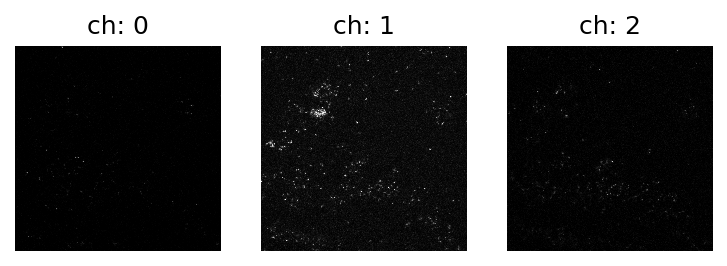

In [6]:
# View images of round 0
fig = plt.figure(dpi=150)
ax1 = fig.add_subplot(131, title='ch: 0')
ax2 = fig.add_subplot(132, title='ch: 1')
ax3 = fig.add_subplot(133, title='ch: 2')
imshow_plane(df_stack, sel={Axes.ROUND: 0, Axes.CH: 0}, ax=ax1)
imshow_plane(df_stack, sel={Axes.ROUND: 0, Axes.CH: 1}, ax=ax2)
imshow_plane(df_stack, sel={Axes.ROUND: 0, Axes.CH: 2}, ax=ax3)

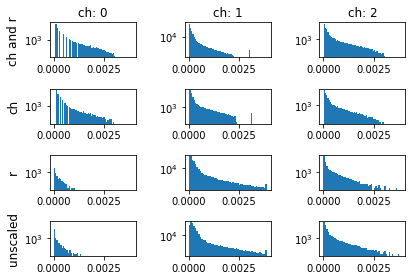

In [15]:
# Plot DARTFISH round 0
plot_intensity_histograms(ref=df_stack, scaled_cr=df_scaled_cr, scaled_c=df_scaled_c, scaled_r=df_scaled_r, r=0)

### Conclusion
Looking at the unscaled histograms in the bottom row, it is clear that ch:0 of the raw data has a different distribution from the other two. Looking at the effect of different group_by arguments in MatchHistogram clearly shows if Axes.CH is an argument in MatchHistogram then 'variability across channels' is lost.

### STARmap data analysis

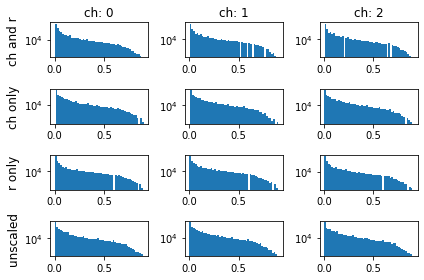

In [105]:
# Plot STARmap round 0
plot_intensity_histograms(ref=sm_stack, scaled_cr=sm_scaled_cr, scaled_c=sm_scaled_c, scaled_r=sm_scaled_r, r=0)

With STARmap data, because there is little variation between channels in this round, it is hard to tell the difference in histograms. We can use 2-sample KS test to quantify similarity between the histograms.

In [24]:
from scipy import stats
"""
stats.ks_2samp(df_scaled_r.get_slice({Axes.ROUND: 0, Axes.CH: 0})[0].ravel(),df_scaled_r.get_slice({Axes.ROUND: 0, Axes.CH: 1})[0].ravel())

stats.ks_2samp(df_scaled_c.get_slice({Axes.ROUND: 0, Axes.CH: 0})[0].ravel(),df_scaled_c.get_slice({Axes.ROUND: 0, Axes.CH: 1})[0].ravel())

stats.ks_2samp(df_scaled_cr.get_slice({Axes.ROUND: 0, Axes.CH: 0})[0].ravel(),df_scaled_cr.get_slice({Axes.ROUND: 0, Axes.CH: 1})[0].ravel())

stats.ks_2samp(df_scaled_r.get_slice({Axes.ROUND: 0, Axes.CH: 0})[0].ravel(),df_scaled_r.get_slice({Axes.ROUND: 1, Axes.CH: 0})[0].ravel())

stats.ks_2samp(df_scaled_c.get_slice({Axes.ROUND: 0, Axes.CH: 0})[0].ravel(),df_scaled_c.get_slice({Axes.ROUND: 1, Axes.CH: 0})[0].ravel())

stats.ks_2samp(df_scaled_cr.get_slice({Axes.ROUND: 0, Axes.CH: 0})[0].ravel(),df_scaled_cr.get_slice({Axes.ROUND: 1, Axes.CH: 0})[0].ravel())

# Unscaled comparing beween rounds
stats.ks_2samp(df_stack.get_slice({Axes.ROUND: 0, Axes.CH: 0})[0].ravel(),df_stack.get_slice({Axes.ROUND: 1, Axes.CH: 0})[0].ravel())

# Unscaled comparing between channels
stats.ks_2samp(df_stack.get_slice({Axes.ROUND: 0, Axes.CH: 0})[0].ravel(),df_stack.get_slice({Axes.ROUND: 0, Axes.CH: 1})[0].ravel())
"""

Ks_2sampResult(statistic=0.9470057696405448, pvalue=0.0)

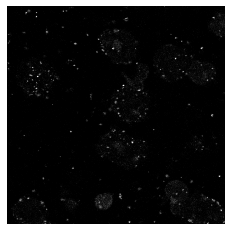

In [49]:
plt.figure(dpi=150)
imshow_plane(sm_scaled_cr, sel={Axes.ROUND: 0, Axes.CH: 0, Axes.ZPLANE: 10})

In [64]:
# Comparing between channels

# Unscaled
print(stats.ks_2samp(df_stack.get_slice({Axes.ROUND: 0, Axes.CH: 0})[0].ravel(),df_stack.get_slice({Axes.ROUND: 0, Axes.CH: 1})[0].ravel()))
# Scaled groupby channels
print(stats.ks_2samp(df_scaled_c.get_slice({Axes.ROUND: 0, Axes.CH: 0})[0].ravel(),df_scaled_c.get_slice({Axes.ROUND: 0, Axes.CH: 1})[0].ravel()))
# Scaled groupby rounds
print(stats.ks_2samp(df_scaled_r.get_slice({Axes.ROUND: 0, Axes.CH: 0})[0].ravel(),df_scaled_r.get_slice({Axes.ROUND: 0, Axes.CH: 1})[0].ravel()))

Ks_2sampResult(statistic=0.9470057696405448, pvalue=0.0)
Ks_2sampResult(statistic=0.7688445557212871, pvalue=0.0)
Ks_2sampResult(statistic=0.9470057696405448, pvalue=0.0)


In [76]:
# Comparing between rounds

# Unscaled
print(stats.ks_2samp(df_stack.get_slice({Axes.ROUND: 0, Axes.CH: 0})[0].ravel(),df_stack.get_slice({Axes.ROUND: 1, Axes.CH: 0})[0].ravel()))
# Scaled groupby channels
print(stats.ks_2samp(df_scaled_c.get_slice({Axes.ROUND: 0, Axes.CH: 0})[0].ravel(),df_scaled_c.get_slice({Axes.ROUND: 1, Axes.CH: 0})[0].ravel()))
# Scaled groupby rounds
print(stats.ks_2samp(df_scaled_r.get_slice({Axes.ROUND: 0, Axes.CH: 0})[0].ravel(),df_scaled_r.get_slice({Axes.ROUND: 1, Axes.CH: 0})[0].ravel()))
# Scaled groupby channels rounds
print(stats.ks_2samp(df_scaled_cr.get_slice({Axes.ROUND: 0, Axes.CH: 0})[0].ravel(),df_scaled_cr.get_slice({Axes.ROUND: 1, Axes.CH: 0})[0].ravel()))

Ks_2sampResult(statistic=0.07621826287924727, pvalue=0.0)
Ks_2sampResult(statistic=0.07621826287924727, pvalue=0.0)
Ks_2sampResult(statistic=0.9371066154173975, pvalue=0.0)
Ks_2sampResult(statistic=0.7706670327328755, pvalue=0.0)


In [77]:
# Comparing between rounds

# Unscaled
print(stats.ks_2samp(sm_stack.get_slice({Axes.ROUND: 0, Axes.CH: 0})[0].ravel(),sm_stack.get_slice({Axes.ROUND: 1, Axes.CH: 0})[0].ravel()))
# Scaled groupby channels
print(stats.ks_2samp(sm_scaled_c.get_slice({Axes.ROUND: 0, Axes.CH: 0})[0].ravel(),sm_scaled_c.get_slice({Axes.ROUND: 1, Axes.CH: 0})[0].ravel()))
# Scaled groupby rounds
print(stats.ks_2samp(sm_scaled_r.get_slice({Axes.ROUND: 0, Axes.CH: 0})[0].ravel(),sm_scaled_r.get_slice({Axes.ROUND: 1, Axes.CH: 0})[0].ravel()))
# Scaled groupby channels rounds
print(stats.ks_2samp(sm_scaled_cr.get_slice({Axes.ROUND: 0, Axes.CH: 0})[0].ravel(),sm_scaled_cr.get_slice({Axes.ROUND: 1, Axes.CH: 0})[0].ravel()))

Ks_2sampResult(statistic=0.1496696131569999, pvalue=0.0)
Ks_2sampResult(statistic=0.1496696131569999, pvalue=0.0)
Ks_2sampResult(statistic=0.8292206696101597, pvalue=0.0)
Ks_2sampResult(statistic=0.8279501710619245, pvalue=0.0)


In [78]:
# Comparing between {r:0,c:0} and {r:1,c:1}

# Unscaled
print(stats.ks_2samp(sm_stack.get_slice({Axes.ROUND: 0, Axes.CH: 0})[0].ravel(),sm_stack.get_slice({Axes.ROUND: 1, Axes.CH: 1})[0].ravel()))
# Scaled groupby channels
print(stats.ks_2samp(sm_scaled_c.get_slice({Axes.ROUND: 0, Axes.CH: 0})[0].ravel(),sm_scaled_c.get_slice({Axes.ROUND: 1, Axes.CH: 1})[0].ravel()))
# Scaled groupby rounds
print(stats.ks_2samp(sm_scaled_r.get_slice({Axes.ROUND: 0, Axes.CH: 0})[0].ravel(),sm_scaled_r.get_slice({Axes.ROUND: 1, Axes.CH: 1})[0].ravel()))
# Scaled groupby channels rounds
print(stats.ks_2samp(sm_scaled_cr.get_slice({Axes.ROUND: 0, Axes.CH: 0})[0].ravel(),sm_scaled_cr.get_slice({Axes.ROUND: 1, Axes.CH: 1})[0].ravel()))

Ks_2sampResult(statistic=0.15433713368007118, pvalue=0.0)
Ks_2sampResult(statistic=0.833888190133231, pvalue=0.0)
Ks_2sampResult(statistic=0.833888190133231, pvalue=0.0)
Ks_2sampResult(statistic=0.8279501710619245, pvalue=0.0)


In [79]:
# Comparing between {r:0,c:0} and {r:1,c:1}

# Unscaled
print(stats.ks_2samp(df_stack.get_slice({Axes.ROUND: 0, Axes.CH: 0})[0].ravel(),df_stack.get_slice({Axes.ROUND: 1, Axes.CH: 1})[0].ravel()))
# Scaled groupby channels
print(stats.ks_2samp(df_scaled_c.get_slice({Axes.ROUND: 0, Axes.CH: 0})[0].ravel(),df_scaled_c.get_slice({Axes.ROUND: 1, Axes.CH: 1})[0].ravel()))
# Scaled groupby rounds
print(stats.ks_2samp(df_scaled_r.get_slice({Axes.ROUND: 0, Axes.CH: 0})[0].ravel(),df_scaled_r.get_slice({Axes.ROUND: 1, Axes.CH: 1})[0].ravel()))
# Scaled groupby channels rounds
print(stats.ks_2samp(df_scaled_cr.get_slice({Axes.ROUND: 0, Axes.CH: 0})[0].ravel(),df_scaled_cr.get_slice({Axes.ROUND: 1, Axes.CH: 1})[0].ravel()))

Ks_2sampResult(statistic=0.6929561622055762, pvalue=0.0)
Ks_2sampResult(statistic=0.9046800472061499, pvalue=0.0)
Ks_2sampResult(statistic=0.9371066154173975, pvalue=0.0)
Ks_2sampResult(statistic=0.7636045501483387, pvalue=0.0)


Interpretation of these results is left up to the reader